# Sparkify Project

This project investigates a dataset that contains logs of user interactions with a music service provider called Sparkify (an artificial firm). The target is to predict whether a user will churn or stay with the service. We will utilize interactions of users with the music service system to make prediction. The final predictive model is expected to mark correctly which user will churn and which user will stay.

This project aims to manipulate a large and realistic dataset with Spark to extract relevant features for predicting churn. We will use Spark MLlib to build machine learning models with large datasets, far beyond what could be done with non-distributed technologies like scikit-learn.
This workspace contains a subset (128MB) of the full dataset available (12GB) to work on. The dataset is available [here](https://udacity-dsnd.s3.amazonaws.com/sparkify/mini_sparkify_event_data.json).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession, Window
from pyspark.ml.feature import VectorAssembler, StandardScaler
import pyspark.sql.functions as sf

In [2]:
# create a Spark session
spark = SparkSession.builder.appName('Sparkify').getOrCreate()

## Load and Clean Dataset
In this workspace, the mini-dataset file is `data_sparkify_event_mini.json`. Let's load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids.

In [3]:
df = spark.read.json('data_sparkify_event_mini.json')
df.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

In [4]:
print('# of rows:', df.count())
print('# of columns:', len(df.columns))

# of rows: 286500
# of columns: 18


In [5]:
# print schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
df.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|            length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+------------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|            228108|286500|           278154|286500| 286500|     

In [7]:
df.show(1, vertical=True)

-RECORD 0-----------------------------
 artist        | Martha Tilston       
 auth          | Logged In            
 firstName     | Colin                
 gender        | M                    
 itemInSession | 50                   
 lastName      | Freeman              
 length        | 277.89016            
 level         | paid                 
 location      | Bakersfield, CA      
 method        | PUT                  
 page          | NextSong             
 registration  | 1538173362000        
 sessionId     | 29                   
 song          | Rockpools            
 status        | 200                  
 ts            | 1538352117000        
 userAgent     | Mozilla/5.0 (Wind... 
 userId        | 30                   
only showing top 1 row



### Filter out missing values

There are rows that don't have any user id.\
Let's investigate why this happened and what should be done to proceed.

In [8]:
# get all user ids
df.select('userId').distinct().orderBy('userId').show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



Records without user ids are likely for users that had not logged in.\
Let's check which pages they (users without ids) visited to confirm.

In [9]:
# list out pages that were visited by users without ids
df.select(['userId', 'auth', 'page']).where(sf.col('userId') == '').distinct().show()

+------+----------+-------------------+
|userId|      auth|               page|
+------+----------+-------------------+
|      |Logged Out|               Home|
|      |Logged Out|               Help|
|      |Logged Out|              About|
|      |Logged Out|              Login|
|      |Logged Out|              Error|
|      |     Guest|               Help|
|      |     Guest|              Error|
|      |     Guest|           Register|
|      |     Guest|               Home|
|      |     Guest|              About|
|      |     Guest|Submit Registration|
+------+----------+-------------------+



We confirm that rows without any value for userId are for those who did not log in for playing songs.
These users are not related to the task of predicting the user churn, so we can remove them. 

In [10]:
# drop records with empty userId
print('before dropna ', df.count())
df = df.filter(df['userId'] != '')  # df.na.drop() dose not works with empty strings ('')
print('after dropna: ', df.count())

before dropna  286500
after dropna:  278154


## Exploratory Data Analysis
<!-- When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore. -->

**Define Churn**: Let's create a new column called `churn` to use as the label for the predictive model. We can use the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. <!-- As a bonus task, you can also look into the `Downgrade` events. -->

**Explore Data**: Once we've defined churn, let's perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. We can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### EDA: Stayed vs. churned users

Cancellation Confirmation is the page that a user proceeds with when they want to cancel their service. Therefore, we identify the users who have churned using the `Cancellation Confirmation` event under the `page` column.

In [11]:
# list all pages on Sparkify
df.select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [12]:
# create a new column calld 'churn' to mark churned users
markChurnEvents = sf.udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, 'integer')
df = df.withColumn('churnEvent', markChurnEvents('page'))
windowval = Window.partitionBy("userId").orderBy(sf.desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
df = df.withColumn("churn", sf.sum("churnEvent").over(windowval))
df.show()

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+-----+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|userId|churnEvent|churn|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+-----+
|                NULL|Logged In| Darianna|     F|           34|Carpenter|     NULL| free|Bridgeport-Stamfo...|   PUT|     Logout|1538016340000|      187|                NULL|   307|1542823952000|"Mozilla/5.0 (iPh...|100010|         0|    0|
|          Lily Allen|Logged In| Dar

In [13]:
# pull out users that churned
uid_churned = df.select(['userId']).where(sf.col('churnEvent')==1)
print('# of users churned:', uid_churned.dropDuplicates().count())

# of users churned: 52


In [14]:
# create a list of churned users
ls_users_churned = [item[0] for item in uid_churned.toPandas().values.tolist()]
print(ls_users_churned)

['18', '32', '125', '105', '17', '143', '101', '129', '121', '51', '87', '122', '12', '58', '73', '3', '106', '103', '28', '54', '29', '70', '53', '100011', '100001', '100024', '100006', '100019', '100003', '100023', '100005', '100017', '100025', '100009', '100012', '100013', '100022', '100014', '100015', '100021', '100007', '200001', '200024', '200011', '200021', '200018', '200015', '200017', '200016', '200020', '300007', '300001']


Churned: 52
Stayed: 173


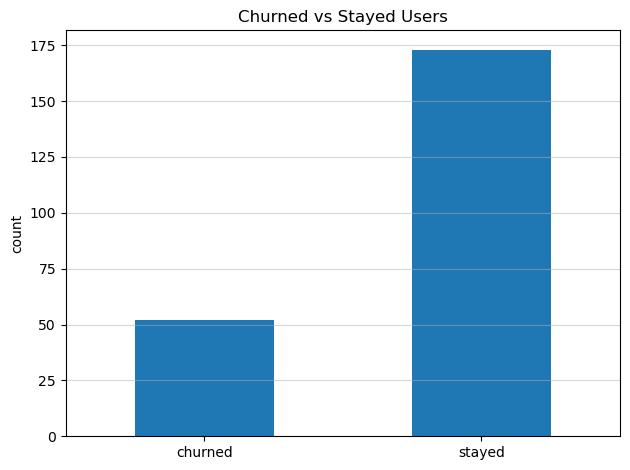

In [15]:
# plotting: # of users churned vs stayed
n_churned = df.select(['userId']).where(sf.col('churnEvent')==1).dropDuplicates().count()
n_stayed = df.select(['userId']).dropDuplicates().count() - n_churned
print('Churned:', n_churned)
print('Stayed:', n_stayed)
pd.DataFrame({'churned': [n_churned], 'stayed': [n_stayed]}).transpose().plot(
    kind='bar', title='Churned vs Stayed Users', rot=0, ylabel='count', legend=False
)
plt.grid(True, axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

In [16]:
print(f'churn rate: {n_churned / (n_churned + n_stayed) * 100:.2f} %')

churn rate: 23.11 %


`Observation`: There are less churned users than those that have stayed (52 vs 172).
The data labels of the dataset are unbalanced.

### EDA: Gender

In [17]:
pdf_gender = df.select(['userId', 'gender', 'churn']).dropDuplicates()\
    .groupBy('gender', 'churn').count()\
    .toPandas().set_index('churn').pivot(columns='gender', values='count')
pdf_gender.head()

gender,F,M
churn,,
0,84,89
1,20,32


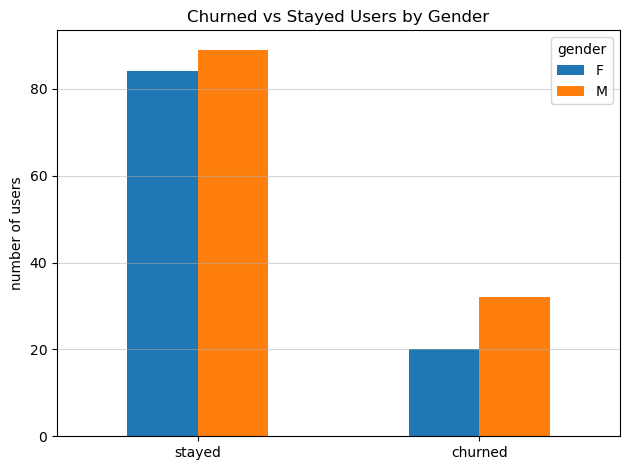

In [18]:
pdf_gender.plot(kind='bar', stacked=False, rot=0,
                title='Churned vs Stayed Users by Gender',
                ylabel='number of users', xlabel='')
plt.grid(True, axis='y', alpha=0.5)
plt.xticks([0, 1], ['stayed', 'churned'])
plt.tight_layout()
plt.show()

`Observation`: The ratio of male vs female for users who have churned is higher than that of users who stayed.

### EDA: Supscription level (paid vs free)
In this section, we examine the churn rate for paid and free users.

In [19]:
churned = df.select(['userId', 'level']).where(sf.col('userId').isin(ls_users_churned)).dropDuplicates().\
    groupBy('level').count().withColumnRenamed('count', 'churned').toPandas().set_index('level')
stayed = df.select(['userId', 'level']).where(~sf.col('userId').isin(ls_users_churned)).dropDuplicates().\
    groupBy('level').count().withColumnRenamed('count', 'stayed').toPandas().set_index('level')

In [20]:
print(f"churn rate for paid users: {churned.loc['paid', 'churned'] / (churned.loc['paid', 'churned'] + stayed.loc['paid', 'stayed']) * 100:.2f} %")
print(f"churn rate for free users: {churned.loc['free', 'churned'] / (churned.loc['free', 'churned'] + stayed.loc['free', 'stayed']) * 100:.2f} %")

churn rate for paid users: 21.82 %
churn rate for free users: 23.59 %


In [21]:
pdf = churned.join(stayed, on='level', how='outer').transpose().sort_index(ascending=False) 
pdf

level,free,paid
stayed,149,129
churned,46,36


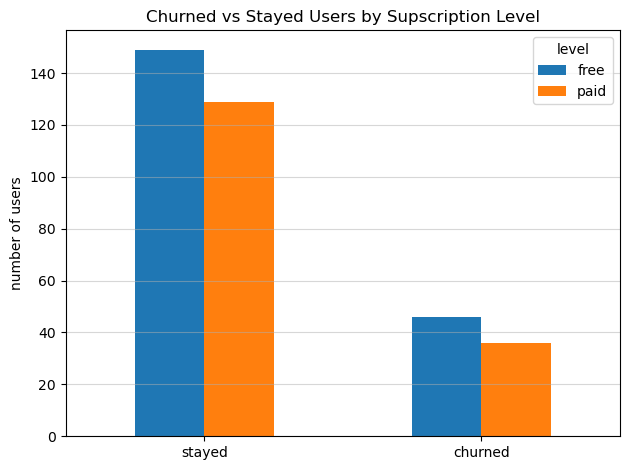

In [22]:
# plotting: churned vs stayed users by subscription level
pdf.plot(kind='bar', title='Churned vs Stayed Users by Supscription Level',
         rot=0, ylabel='number of users', legend=True)
plt.tight_layout()
plt.grid(axis='y', alpha=0.5, zorder=-1)
plt.show()

`Observation`: the churn rate for paid users (21.82%) is slightly lower than that of free users (23.59%). 

### EDA: Pages visited and user behaviors
We can investigate the user behavior by examining which pages are frequently visited by churned and stayed users.

In [23]:
# get the number of hits for each page
df_page = df.select(['userId', 'churn', 'page']).groupBy('page','churn').count()
df_page.show(100)

+--------------------+-----+------+
|                page|churn| count|
+--------------------+-----+------+
|            Settings|    0|  1244|
|         Thumbs Down|    1|   496|
|           Thumbs Up|    1|  1859|
|     Add to Playlist|    1|  1038|
|               Error|    1|    32|
|               About|    1|    56|
|         Thumbs Down|    0|  2050|
|         Roll Advert|    1|   967|
|                Home|    0|  8410|
|Cancellation Conf...|    1|    52|
|               Error|    0|   220|
|              Cancel|    1|    52|
|            Settings|    1|   270|
|          Add Friend|    1|   636|
|             Upgrade|    0|   387|
|           Downgrade|    1|   337|
|              Logout|    1|   553|
|    Submit Downgrade|    1|     9|
|       Save Settings|    0|   252|
|           Thumbs Up|    0| 10692|
|           Downgrade|    0|  1718|
|      Submit Upgrade|    0|   127|
|         Roll Advert|    0|  2966|
|    Submit Downgrade|    0|    54|
|              Logout|    0|

In [24]:
# get the number of page hits for each type of user
df_page = df_page.groupBy('page').pivot('churn').sum('count').na.fill(0)
df_page.show(100)

+--------------------+------+-----+
|                page|     0|    1|
+--------------------+------+-----+
|              Cancel|     0|   52|
|    Submit Downgrade|    54|    9|
|         Thumbs Down|  2050|  496|
|                Home|  8410| 1672|
|           Downgrade|  1718|  337|
|         Roll Advert|  2966|  967|
|              Logout|  2673|  553|
|       Save Settings|   252|   58|
|Cancellation Conf...|     0|   52|
|               About|   439|   56|
|            Settings|  1244|  270|
|     Add to Playlist|  5488| 1038|
|          Add Friend|  3641|  636|
|            NextSong|191714|36394|
|           Thumbs Up| 10692| 1859|
|                Help|  1215|  239|
|             Upgrade|   387|  112|
|               Error|   220|   32|
|      Submit Upgrade|   127|   32|
+--------------------+------+-----+



In [25]:
# calculate the percentage of page hits for each type of user
total_chunred = df_page.select(sf.sum('1')).collect()[0][0]
total_stayed = df_page.select(sf.sum('0')).collect()[0][0]
df_page = df_page.withColumn('stayed', sf.col('0') / total_stayed * 100)\
    .withColumn('churned', sf.col('1') / total_chunred * 100)
df_page.show(100)

+--------------------+------+-----+--------------------+--------------------+
|                page|     0|    1|              stayed|             churned|
+--------------------+------+-----+--------------------+--------------------+
|              Cancel|     0|   52|                 0.0| 0.11590584878744652|
|    Submit Downgrade|    54|    9|0.023147155900381498|0.020060627674750357|
|         Thumbs Down|  2050|  496|  0.8787346221441126|  1.1055634807417976|
|                Home|  8410| 1672|  3.6049552059668226|  3.7268188302425105|
|           Downgrade|  1718|  337|  0.7364224784602855|  0.7511590584878745|
|         Roll Advert|  2966|  967|  1.2713789703802134|  2.1554029957203995|
|              Logout|  2673|  553|  1.1457842170688843|   1.232614122681883|
|       Save Settings|   252|   58|   0.108020060868447|  0.1292796005706134|
|Cancellation Conf...|     0|   52|                 0.0| 0.11590584878744652|
|               About|   439|   56| 0.18817780444939775| 0.12482

In [26]:
# plotting: page hits for stayed vs churned users
pdf_page = df_page.toPandas().melt(
    id_vars='page', var_name='user_type', value_vars=['stayed', 'churned'],
    value_name='percentage'
).sort_values('percentage', ascending=False)
pdf_page.head(100)

,page,user_type,percentage
13,NextSong,stayed,82.178405
32,NextSong,churned,81.120720
14,Thumbs Up,stayed,4.583137
33,Thumbs Up,churned,4.143634
22,Home,churned,3.726819
3,Home,stayed,3.604955
11,Add to Playlist,stayed,2.352437
30,Add to Playlist,churned,2.313659
24,Roll Advert,churned,2.155403
12,Add Friend,stayed,1.560718


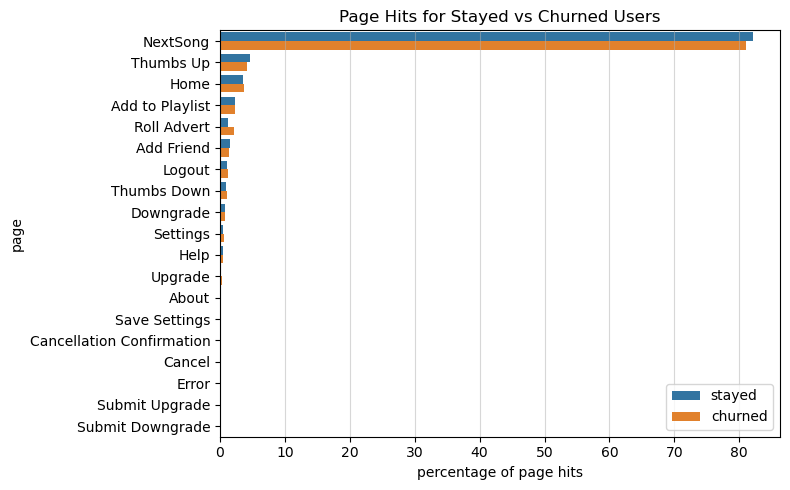

In [27]:
plt.figure(figsize=(8, 5))
sns.barplot(x='percentage', y='page', hue='user_type', data=pdf_page)
plt.grid(axis='x', alpha=0.5, zorder=0)
plt.title('Page Hits for Stayed vs Churned Users')
plt.xlabel('percentage of page hits')
plt.tight_layout()
plt.legend(title='', loc='lower right')
plt.show()

`Observation`:
- `NextSong` is the page that both stayed and churned access to most frequently.
- Users who stayed tend to access to the `Thumbs Up` and `Add friend` pages more often than those who leaved.
- In contrast, users who have churned from Sparkify have more clicks on `Roll Advert`, `Logout`, and `Thumbs Down` pages than stayed users.

### EDA: Songs played per hour

In [28]:
# create a new column called 'hour' and 'datetime' to convert the timestamp
df = df.withColumn('datetime', sf.to_timestamp(sf.from_unixtime(sf.col('ts')/1000)))
df = df.withColumn('hour', sf.hour(sf.col('datetime')))

In [29]:
# calculate the number of songs played by hour for the churned and stayed users
byHour_churned = df.filter((sf.col('userId').isin(ls_users_churned)) & (sf.col('page')=='NextSong'))\
    .groupBy('hour').agg(
        sf.count('page').alias('totalSongsByHour'),
        sf.countDistinct('userId').alias('uniqueUsersByHour'),
        (sf.count('page')/sf.countDistinct('userId')).alias('avgSongsByHour')
    ).orderBy('hour').toPandas()
    
byHour_stayed = df.filter(~sf.col('userId').isin(ls_users_churned) & (sf.col('page')=='NextSong'))\
    .groupBy('hour').agg(
        sf.count('page').alias('totalSongsByHour'),
        sf.countDistinct('userId').alias('uniqueUsersByHour'),
        (sf.count('page')/sf.countDistinct('userId')).alias('avgSongsByHour')
    ).orderBy('hour').toPandas()
    
pdf = pd.concat([byHour_churned, byHour_stayed], axis=1)

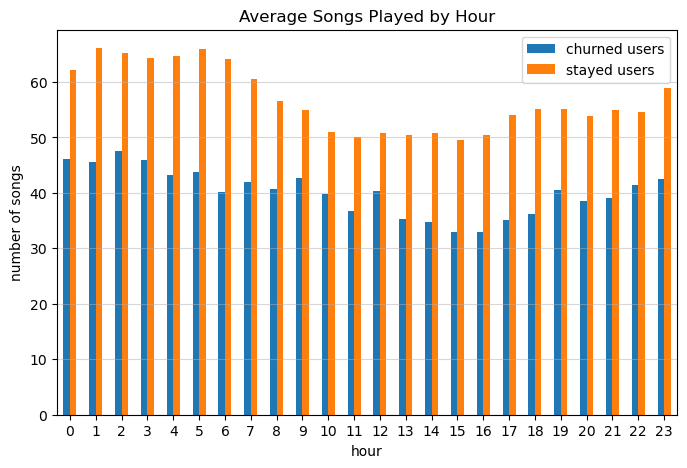

In [30]:
# plotting: number of songs played by hour
byHour_churned.join(byHour_stayed, on='hour', how='outer', lsuffix='_churned', rsuffix='_stayed')\
    .plot(x='hour', y=['avgSongsByHour_churned', 'avgSongsByHour_stayed'],
          title='Average Songs Played by Hour', ylabel='number of songs', rot=0,
          label=['churned users', 'stayed users'], kind='bar', figsize=(8, 5))
plt.grid(axis='y', alpha=0.5, zorder=0)
plt.show()

`Observation`:
- Evenings and midnights are high-traffic hours for both churned and stayed users.
- On average, users who stay play more songs in an hour than users who leave.

### EDA: Songs played per session

In [31]:
df.select(['level']).distinct().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [32]:
songsBySession = df.select(['userId', 'page', 'sessionId', 'churn']).where(sf.col('page')=='NextSong')\
    .groupBy('userId', 'sessionId', 'churn').count().toPandas()

In [33]:
songsBySession

,userId,sessionId,churn,count
0,100,2428,0,81
1,100,2304,0,156
2,100,2240,0,19
3,100,2135,0,28
4,100,2075,0,200
...,...,...,...,...
3066,97,698,0,8
3067,97,679,0,2
3068,97,550,0,47
3069,97,96,0,12


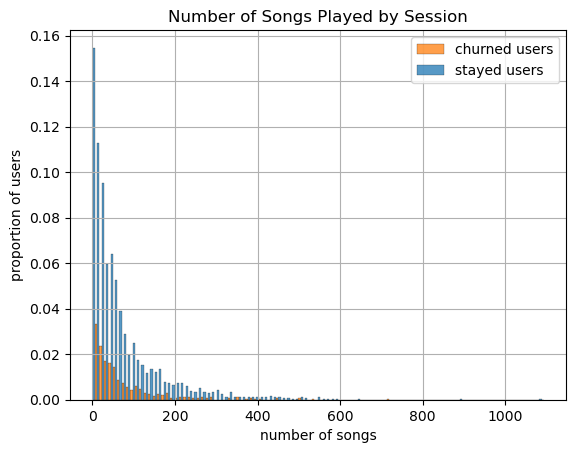

In [34]:
# plt.figure(figsize=(8, 5))
sns.histplot(x='count', data=songsBySession, hue='churn', multiple = "dodge", stat='proportion')
plt.grid(True)
plt.legend({'churned users': 1, 'stayed users': 0})
plt.xlabel('number of songs')
plt.title('Number of Songs Played by Session')
plt.ylabel('proportion of users')
plt.show()

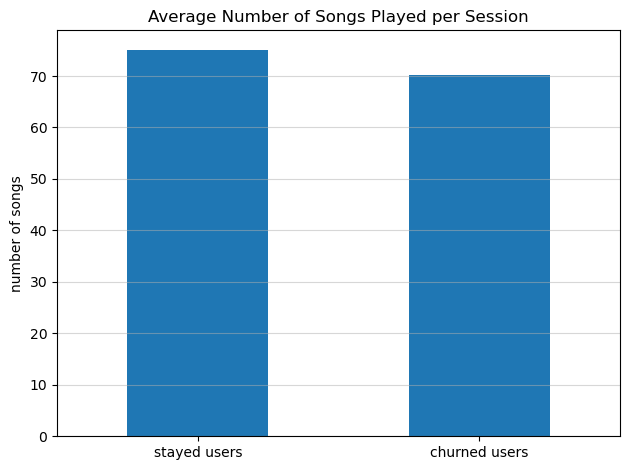

In [35]:
df.where(sf.col('page')=='NextSong')\
    .groupBy('userId', 'sessionId', 'churn').count()\
    .groupBy('churn').agg(sf.avg('count').alias('avgSongsPerSession'))\
    .toPandas().plot(kind='bar', x='churn', y='avgSongsPerSession', rot=0,
                     legend=False, xlabel='', ylabel='number of songs',
                     title='Average Number of Songs Played per Session')
plt.grid(axis='y', alpha=0.5)
plt.xticks([0, 1], ['stayed users', 'churned users'])
plt.tight_layout()
plt.show()

`Observation`: Users who stayed play more songs in a session than those who leaved. 

### EDA: Days since registration

In [36]:
# pull out the most recent event for each user
df_days = df.select(['userId', 'registration', 'ts', 'churn']).dropDuplicates().sort('userId')
w = Window.partitionBy("userId").orderBy(sf.desc("ts"))
df_days = df_days.withColumn("Rank", sf.dense_rank().over(w)) # create Rank col with w/ the most recent event ranked #1
df_days = df_days.filter(df_days.Rank == 1).drop("Rank")  # filter out all but the most recent event
df_days.show()

+------+-------------+-------------+-----+
|userId| registration|           ts|churn|
+------+-------------+-------------+-----+
|    10|1538159495000|1542631788000|    0|
|   100|1537982255000|1543587349000|    0|
|100001|1534627466000|1538498205000|    1|
|100002|1529934689000|1543799476000|    0|
|100003|1537309344000|1539274781000|    1|
|100004|1528560242000|1543459065000|    0|
|100005|1532610926000|1539971825000|    1|
|100006|1537964483000|1538753070000|    1|
|100007|1533522419000|1543491909000|    1|
|100008|1537440271000|1543335219000|    0|
|100009|1537376437000|1540611104000|    1|
|100010|1538016340000|1542823952000|    0|
|100011|1537970819000|1538417085000|    1|
|100012|1537381154000|1541100900000|    1|
|100013|1537367773000|1541184816000|    1|
|100014|1535389443000|1542740649000|    1|
|100015|1537208989000|1543073753000|    1|
|100016|1536854322000|1543335647000|    0|
|100017|1533247234000|1540062847000|    1|
|100018|1533812833000|1543378360000|    0|
+------+---

In [37]:
# calculate the number of days since registration
df_days = df_days.withColumn("delta_days", (df_days['ts']) - (df_days['registration']))
df_days = df_days.withColumn("delta_days", sf.col("delta_days") / (1000 * 60 * 60 * 24))
df_days.show()

+------+-------------+-------------+-----+------------------+
|userId| registration|           ts|churn|        delta_days|
+------+-------------+-------------+-----+------------------+
|    10|1538159495000|1542631788000|    0| 51.76265046296297|
|   100|1537982255000|1543587349000|    0| 64.87377314814815|
|100001|1534627466000|1538498205000|    1| 44.80021990740741|
|100002|1529934689000|1543799476000|    0|160.47207175925925|
|100003|1537309344000|1539274781000|    1|22.748113425925926|
|100004|1528560242000|1543459065000|    0|172.44008101851853|
|100005|1532610926000|1539971825000|    1| 85.19559027777778|
|100006|1537964483000|1538753070000|    1| 9.127164351851851|
|100007|1533522419000|1543491909000|    1|115.38761574074074|
|100008|1537440271000|1543335219000|    0| 68.22856481481482|
|100009|1537376437000|1540611104000|    1| 37.43827546296296|
|100010|1538016340000|1542823952000|    0| 55.64365740740741|
|100011|1537970819000|1538417085000|    1| 5.165115740740741|
|100012|

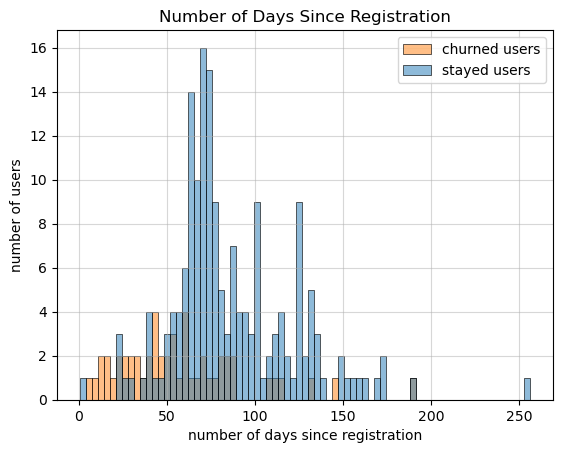

In [38]:
# plotting: number of days since registration
sns.histplot(data=df_days.toPandas(), x='delta_days', hue='churn', bins=75)
plt.title('Number of Days Since Registration')
plt.xlabel('number of days since registration')
plt.ylabel('number of users')
plt.grid(True, alpha=0.5)
plt.legend({'churned users': 1, 'stayed users': 0})
plt.show()

`Observation`:
- Users who stay for a longer time are less likely to leave Sparkify.
- Recently registered users are more likely to churn.


# Feature Engineering
*Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.*
- *Write a script to extract the necessary features from the smaller subset of data*
- *Ensure that your script is scalable, using the best practices discussed in Lesson 3*
- *Try your script on the full data set, debugging your script if necessary*

*If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.*

Based on observations from the EDA in the previous section, I select the following features that seem to be most promissing for building a predictive model:
- gender (male or female)
- subscription level (paid or free users)
- number of thumbs-up actions
- number of roll-add actions
- number of logout actions
- number of thumbs-down actions
- number of add-friend actions
- number of songs played per hour
- number of songs played per session
- number of days since registration

The target is to create a dataframe where each row presents information used for prediction for each user, together with a label denoting churned/stayed users. Later on, the feature matrix will be pre-processed with vectorization and standardization before being fed into the predictive model.

## FE: Gender
We use binary encoding to encode gender information, 1 for male and 0 for female users.

In [39]:
fe_gender = df.select(['userId','gender']).dropDuplicates()\
    .withColumn('gender', sf.when(sf.col('gender') == 'M', 1).otherwise(0))
fe_gender.show(5)

+------+------+
|userId|gender|
+------+------+
|    44|     0|
|    46|     0|
|    41|     0|
|    39|     0|
|    40|     0|
+------+------+
only showing top 5 rows



In [40]:
fe_gender.count()

225

## FE: Subscription level
Users can change from free to paid subscriptions and vice versa. Therefore, we select only the most recent subscription status for each user. We then encode 1 for paid and 0 for free users.

In [41]:
# extract the most recent subscription level for each user
df_level = df.select(['userId', 'level', 'ts']).dropDuplicates().sort('userId')
w = Window.partitionBy("userId").orderBy(sf.desc("ts"))
df_level = df_level.withColumn("Rank", sf.dense_rank().over(w))
df_level = df_level.filter(df_level.Rank == 1).drop("Rank").drop('ts')
df_level.show(5)

+------+-----+
|userId|level|
+------+-----+
|    10| paid|
|   100| paid|
|100001| free|
|100002| paid|
|100003| free|
+------+-----+
only showing top 5 rows



In [42]:
# encode the subscription level: 1=paid, 0=free
checkSubLevel = sf.udf(lambda x: 1 if x == 'paid' else 0, 'integer')
df_level = df_level.withColumn('subscription', checkSubLevel('level'))
fe_level = df_level.drop("level")
fe_level.show(5)

+------+------------+
|userId|subscription|
+------+------------+
|    10|           1|
|   100|           1|
|100001|           0|
|100002|           1|
|100003|           0|
+------+------------+
only showing top 5 rows



In [43]:
fe_level.count()

225

## FE: Number of thumbs-up actions
We calculate the number of likes for each user to be used as a predictive feature. 

In [44]:
# calculate the number of likes for each user
fe_thumbsUp = df.select(['userId', 'page']).where(sf.col('page')=='Thumbs Up')\
    .groupBy('userId').count().withColumnRenamed('count', 'thumbsUp')
fe_thumbsUp.show(5)

+------+--------+
|userId|thumbsUp|
+------+--------+
|    51|     100|
|   124|     171|
|    54|     163|
|    15|      81|
|   132|      96|
+------+--------+
only showing top 5 rows



In [45]:
fe_thumbsUp.count()

220

## FE: Number of roll-ad actions
Similarly, the number of roll-ad actions is utilized as a predictive feature.

In [46]:
# calculate the number of roll-ad actions for each user
fe_rollAd = df.select(['userId', 'page']).where(sf.col('page')=='Roll Advert')\
    .groupBy('userId').count().withColumnRenamed('count', 'rollAdvert')
fe_rollAd.show(5)

+------+----------+
|userId|rollAdvert|
+------+----------+
|     7|        16|
|   124|         4|
|    54|        47|
|   101|         8|
|   138|        17|
+------+----------+
only showing top 5 rows



In [47]:
fe_rollAd.count()

207

## FE: Number of logout actions

In [48]:
# calculate the number of logouts for each user
fe_logOut = df.select(['userId', 'page']).where(sf.col('page')=='Logout')\
    .groupBy('userId').count().withColumnRenamed('count', 'logOut')
fe_logOut.show(5)

+------+------+
|userId|logOut|
+------+------+
|    51|    24|
|   124|    59|
|     7|     3|
|    15|    27|
|    54|    36|
+------+------+
only showing top 5 rows



In [49]:
fe_logOut.count()

213

## FE: Number of thumbs-down actions

In [50]:
# calculate the number of dislikes for each user
fe_thumbsDown = df.select(['userId', 'page']).where(sf.col('page')=='Thumbs Down')\
    .groupBy('userId').count().withColumnRenamed('count', 'thumbsDown')
fe_thumbsDown.show(5)

+------+----------+
|userId|thumbsDown|
+------+----------+
|    51|        21|
|   124|        41|
|     7|         1|
|    15|        14|
|    54|        29|
+------+----------+
only showing top 5 rows



In [51]:
fe_thumbsDown.count()

203

## FE: Number of add-friend actions

In [52]:
# calculate the number of friends added for each user
fe_addFriend = df.select(['userId', 'page']).where(sf.col('page')=='Add Friend')\
    .groupBy('userId').count().withColumnRenamed('count', 'addFriend')
fe_addFriend.show(5)

+------+---------+
|userId|addFriend|
+------+---------+
|    51|       28|
|   124|       74|
|     7|        1|
|    54|       33|
|    15|       31|
+------+---------+
only showing top 5 rows



In [53]:
fe_addFriend.count()

206

## FE: Songs played per hour

In [54]:
# calculate the number of songs played per hour for each user
fe_songsByHour = df.filter(sf.col('page')=='NextSong')\
    .groupBy('userId', 'hour').count()\
    .groupBy('userId').agg(sf.avg('count').alias('songsByHour'))
fe_songsByHour.show(5)

+------+------------------+
|userId|       songsByHour|
+------+------------------+
|100010|16.176470588235293|
|200002| 20.36842105263158|
|   125|               8.0|
|   124|169.95833333333334|
|    51| 87.95833333333333|
+------+------------------+
only showing top 5 rows



In [55]:
fe_songsByHour.count()

225

## FE: Songs played per session

In [56]:
# calculate the number of songs played per session for each user
fe_songsBySession = df.filter(sf.col('page')=='NextSong')\
    .groupBy('userId', 'sessionId').count()\
    .groupBy('userId').agg(sf.avg('count').alias('songsBySession'))
fe_songsBySession.show(5)

+------+------------------+
|userId|    songsBySession|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|   124|145.67857142857142|
|    51|             211.1|
+------+------------------+
only showing top 5 rows



In [57]:
fe_songsBySession.count()

225

## FE: Days since registration

In [58]:
# calculate the number of days since registration for each user
fe_days = df_days.select(['userId', 'delta_days']).withColumnRenamed('delta_days', 'days')
fe_days.show(5)

+------+------------------+
|userId|              days|
+------+------------------+
|    10| 51.76265046296297|
|   100| 64.87377314814815|
|100001| 44.80021990740741|
|100002|160.47207175925925|
|100003|22.748113425925926|
+------+------------------+
only showing top 5 rows



In [59]:
fe_days.count()

225

## Data Labeling & Feature 
We encode 1 for users who left and 0 for users who stayed. 

In [60]:
# labeling: 1 = churned users, 0 = stayed users
label = df.select(['userId', 'churn']).dropDuplicates().withColumnRenamed('churn', 'label')
label.show(5)

+------+-----+
|userId|label|
+------+-----+
|    10|    0|
|   100|    0|
|100001|    1|
|100002|    0|
|100003|    1|
+------+-----+
only showing top 5 rows



In [61]:
label.count()

225

In [62]:
# join all features into a single dataframe
fe_matrix = fe_gender.join(fe_level, on='userId', how='outer')\
    .join(fe_thumbsUp, on='userId', how='outer')\
    .join(fe_rollAd, on='userId', how='outer')\
    .join(fe_logOut, on='userId', how='outer')\
    .join(fe_thumbsDown, on='userId', how='outer')\
    .join(fe_addFriend, on='userId', how='outer')\
    .join(fe_songsByHour, on='userId', how='outer')\
    .join(fe_songsBySession, on='userId', how='outer')\
    .join(fe_days, on='userId', how='outer')\
    .na.fill(0)
fe_matrix.show(5)

+------+------+------------+--------+----------+------+----------+---------+------------------+------------------+------------------+
|userId|gender|subscription|thumbsUp|rollAdvert|logOut|thumbsDown|addFriend|       songsByHour|    songsBySession|              days|
+------+------+------------+--------+----------+------+----------+---------+------------------+------------------+------------------+
|    10|     1|           1|      37|         1|    11|         4|       12|28.041666666666668|112.16666666666667| 51.76265046296297|
|   100|     1|           1|     148|        25|    35|        27|       49|            111.75| 78.88235294117646| 64.87377314814815|
|100001|     0|           0|       8|        14|     7|         2|        2|11.083333333333334|             33.25| 44.80021990740741|
|100002|     0|           1|       5|         3|     1|         0|        1|              15.0|             48.75|160.47207175925925|
|100003|     0|           0|       3|         9|     3|       

In [63]:
# add the label column to the feature matrix
df_features = fe_matrix.join(label, on='userId', how='outer').drop('userId')
df_features.show(5)

+------+------------+--------+----------+------+----------+---------+------------------+------------------+------------------+-----+
|gender|subscription|thumbsUp|rollAdvert|logOut|thumbsDown|addFriend|       songsByHour|    songsBySession|              days|label|
+------+------------+--------+----------+------+----------+---------+------------------+------------------+------------------+-----+
|     1|           1|      37|         1|    11|         4|       12|28.041666666666668|112.16666666666667| 51.76265046296297|    0|
|     1|           1|     148|        25|    35|        27|       49|            111.75| 78.88235294117646| 64.87377314814815|    0|
|     0|           0|       8|        14|     7|         2|        2|11.083333333333334|             33.25| 44.80021990740741|    1|
|     0|           1|       5|         3|     1|         0|        1|              15.0|             48.75|160.47207175925925|    0|
|     0|           0|       3|         9|     3|         0|        0|

In [64]:
df_features.describe().show(5)

+-------+-------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+-------------------+------------------+
|summary|             gender|      subscription|          thumbsUp|        rollAdvert|            logOut|        thumbsDown|        addFriend|       songsByHour|   songsBySession|               days|             label|
+-------+-------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+-------------------+------------------+
|  count|                225|               225|               225|               225|               225|               225|              225|               225|              225|                225|               225|
|   mean| 0.5377777777777778|0.6444444444444445|55.782222222222224|             17.48|14.337777777777777|11.315555555555555|

In [65]:
df_features.printSchema()

root
 |-- gender: integer (nullable = true)
 |-- subscription: integer (nullable = true)
 |-- thumbsUp: long (nullable = true)
 |-- rollAdvert: long (nullable = true)
 |-- logOut: long (nullable = true)
 |-- thumbsDown: long (nullable = true)
 |-- addFriend: long (nullable = true)
 |-- songsByHour: double (nullable = true)
 |-- songsBySession: double (nullable = true)
 |-- days: double (nullable = true)
 |-- label: long (nullable = true)



In [66]:
# convert data type to double
for col in df_features.columns:
    df_features = df_features.withColumn(col, sf.col(col).cast('double'))

df_features.printSchema()

root
 |-- gender: double (nullable = true)
 |-- subscription: double (nullable = true)
 |-- thumbsUp: double (nullable = true)
 |-- rollAdvert: double (nullable = true)
 |-- logOut: double (nullable = true)
 |-- thumbsDown: double (nullable = true)
 |-- addFriend: double (nullable = true)
 |-- songsByHour: double (nullable = true)
 |-- songsBySession: double (nullable = true)
 |-- days: double (nullable = true)
 |-- label: double (nullable = true)



## Vector Assembler

In [67]:
# assemble all features into a single vector
assembler = VectorAssembler(inputCols=df_features.columns[:-1], outputCol='features')
df_features = assembler.transform(df_features)
df_features.show(5)

+------+------------+--------+----------+------+----------+---------+------------------+------------------+------------------+-----+--------------------+
|gender|subscription|thumbsUp|rollAdvert|logOut|thumbsDown|addFriend|       songsByHour|    songsBySession|              days|label|            features|
+------+------------+--------+----------+------+----------+---------+------------------+------------------+------------------+-----+--------------------+
|   1.0|         1.0|    37.0|       1.0|  11.0|       4.0|     12.0|28.041666666666668|112.16666666666667| 51.76265046296297|  0.0|[1.0,1.0,37.0,1.0...|
|   1.0|         1.0|   148.0|      25.0|  35.0|      27.0|     49.0|            111.75| 78.88235294117646| 64.87377314814815|  0.0|[1.0,1.0,148.0,25...|
|   0.0|         0.0|     8.0|      14.0|   7.0|       2.0|      2.0|11.083333333333334|             33.25| 44.80021990740741|  1.0|[0.0,0.0,8.0,14.0...|
|   0.0|         1.0|     5.0|       3.0|   1.0|       0.0|      1.0|       

## Standardization

In [68]:
# standardize the features
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures', withStd=True)
scalerModel = scaler.fit(df_features)
df_features = scalerModel.transform(df_features)
df_features.show(5)

+------+------------+--------+----------+------+----------+---------+------------------+------------------+------------------+-----+--------------------+--------------------+
|gender|subscription|thumbsUp|rollAdvert|logOut|thumbsDown|addFriend|       songsByHour|    songsBySession|              days|label|            features|      scaledFeatures|
+------+------------+--------+----------+------+----------+---------+------------------+------------------+------------------+-----+--------------------+--------------------+
|   1.0|         1.0|    37.0|       1.0|  11.0|       4.0|     12.0|28.041666666666668|112.16666666666667| 51.76265046296297|  0.0|[1.0,1.0,37.0,1.0...|[2.00127105192366...|
|   1.0|         1.0|   148.0|      25.0|  35.0|      27.0|     49.0|            111.75| 78.88235294117646| 64.87377314814815|  0.0|[1.0,1.0,148.0,25...|[2.00127105192366...|
|   0.0|         0.0|     8.0|      14.0|   7.0|       2.0|      2.0|11.083333333333334|             33.25| 44.80021990740741

In [69]:
df_features.select(['features', 'scaledFeatures', 'label']).head(1)

[Row(features=DenseVector([1.0, 1.0, 37.0, 1.0, 11.0, 4.0, 12.0, 28.0417, 112.1667, 51.7627]), scaledFeatures=DenseVector([2.0013, 2.0844, 0.5651, 0.0464, 0.7168, 0.3059, 0.583, 0.6358, 2.6321, 1.3744]), label=0.0)]

# Modeling
<!-- *Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.* -->

### Algorithms
Churn prediction is a binary classification problem where we want to predict whether a user will churn from or stay with Sparkify. 
The following machine learning algorithms are suitable for our binary classification problem and will be investigated:
 - **Logistic Regression**: Given the binary classification nature of the problem, logistic regression is a solid choice.  It offers a well-explained model, is simple to implement and interpret, trains efficiently, and is less prone to overfitting.
 - **Random Forest Classifier**: Random Forest is a strong classification algorithm in supervised learning.  As an ensemble method, it constructs numerous decision trees and bases its final prediction on a majority vote, reducing the risk of overfitting.  Its robustness and effectiveness with imbalanced datasets make it suitable for this particular task.
 - **Gradient-Boosted Tree Classifier**: Gradient Boosting Trees (GBT) offers high predictive accuracy by sequentially building trees, with each new tree correcting the errors of its predecessor.  This contrasts with Random Forest, which constructs trees independently. While GBT has a potential for overfitting that requires attention, its strong performance with imbalanced data makes it a viable option for this project.
 - **Linear Support Vector Machine**: Support Vector Classifier (SVC) is a supervised learning algorithm used for binary classification.  It performs well when there's a clear separation between classes and is efficient in terms of memory usage.
 - **Naive Bayes**: Lastly, we will use Naive Bayes, a classifier known for its ease of implementation and speed.

### Metrics
The F1-score is selected to evaluate the performance of our classification models. It provides a more balanced measure of accuracy than simply looking at overall accuracy, especially when dealing with imbalanced datasets like ours. Specifically, the F1 score combines precision and recall, giving a better indication of misclassifications.

The definition of the F1-score and accuracy metric is given below, where $TP$ = True Positive, $TN$ = True Negative, $FP$ = False Positive, and $FN$ = False Negative.
$$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$
$$\text{F1-score} = 2\times\frac{\text{Precision}\times\text{Recall}}{\text{Precision} + \text{Recall}} = \frac{2TP}{2TP + FP + FN}$$


### Techniques
All predictive models will be trained on the training set and evaluated on the validation set.
The selected model will be based on the accuracy (F1-score) and training time.
After selecting the model, we fine-tune its parameters by cross-validation and grid search techniques to find the best one. Lastly, the importance factor for each feature of the final model will be investigated.

## Train/Test/Validaton Split

In [70]:
df_features.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|  173|
|  1.0|   52|
+-----+-----+



In [71]:
# split the data into training, testing, and validation sets
train, test, valid = df_features.randomSplit([0.6, 0.2, 0.2], seed=42)
print('train: ', train.count())
print('test: ', test.count())
print('validation: ', valid.count())

train:  136
test:  54
validation:  35


## Model Selection


In [72]:
# instantiate all classifiers
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from time import time

lr = LogisticRegression(maxIter=10, featuresCol='scaledFeatures', labelCol='label')
rf = RandomForestClassifier(featuresCol='scaledFeatures', labelCol='label', seed=42)
gbt = GBTClassifier(featuresCol='scaledFeatures', labelCol='label', seed=42)
lsvc = LinearSVC(featuresCol='scaledFeatures', labelCol='label')
nb = NaiveBayes(featuresCol='scaledFeatures', labelCol='label')

In [73]:
# evaluate all the models

models = [lr, rf, gbt, lsvc, nb]
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')

for model in models:
    t_start = time()
    model = model.fit(train)
    t_train = time() - t_start
    t_start = time()
    prediction = model.transform(valid)
    t_predict = time() - t_start
    f1 = evaluator.evaluate(prediction)
    accuracy = prediction.filter(prediction.label == prediction.prediction).count() / prediction.count()
    print(f'''{model}
          f1 score: {f1}
          training time: {t_train:.2f} s
          prediction time: {t_predict:.2f} s
          accuracy: {accuracy:.2f}\n''')

LogisticRegressionModel: uid=LogisticRegression_ecd3451d0872, numClasses=2, numFeatures=10
          f1 score: 0.7253644314868806
          training time: 136.72 s
          prediction time: 0.08 s
          accuracy: 0.74

RandomForestClassificationModel: uid=RandomForestClassifier_f34c057e6108, numTrees=20, numClasses=2, numFeatures=10
          f1 score: 0.7253644314868806
          training time: 170.31 s
          prediction time: 0.09 s
          accuracy: 0.74

GBTClassificationModel: uid = GBTClassifier_ad08c7c76e62, numTrees=20, numClasses=2, numFeatures=10
          f1 score: 0.6829206349206348
          training time: 81.74 s
          prediction time: 0.07 s
          accuracy: 0.69

LinearSVCModel: uid=LinearSVC_b105ec02a677, numClasses=2, numFeatures=10
          f1 score: 0.6885714285714286
          training time: 165.55 s
          prediction time: 0.07 s
          accuracy: 0.71

NaiveBayesModel: uid=NaiveBayes_c9a5ef370bd6, modelType=multinomial, numClasses=2, numFea

|| Logistic Regression | Random Forest | GBT Classifier | Linear SVC | Naive Bayes |
| --- | --- | --- | --- | --- | --- |
|F1-score| **0.725** | **0.725** | 0.683 | 0.689 | 0.547 |
|Accuracy| **0.74** | **0.74** | 0.69 | 0.71 | 0.66 |
|Training time (s)| 136.72 | 170.31 | 81.74 | 165.55 | **73.55** |

We observe that `Logistic Regression` performed best in terms of the F1-score with reasonable running time.
I will choose this algorithm to fine-tune its parameters to obtain the final model.

## Model Tuning

The F1-score for Logistic Regression with default settings is 0.725 on the validation set.
Let's see whether we can improve this performance by tuning the model parameters with the cross-validation technique.
First, let's look at the parameters of the logistic regression model.

In [74]:
# print out the Logistic Regression model's parameters
print('Logistic Regression:')
print(lr.explainParams())

Logistic Regression:
aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: scaledFeatures)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound co

I select the following parameters for tuning:
- **aggregationDepth**: increase the depth for treeAggregate to improve the prediction performance.
- **regParam**: non-zero regularization parameters to avoid overfitting.
- **elasticNetParam**: the ElasticNet mixing parameter with alpha=0.5 for a mixing of L1 and L2 penalty.



In [80]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = ParamGridBuilder()\
    .addGrid(lr.aggregationDepth, [2, 5])\
    .addGrid(lr.regParam, [0.1, 0.01])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5])\
    .build()

crossval = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid,
                          evaluator=evaluator, numFolds=3)

In [81]:
%%time
cvModel = crossval.fit(train)

CPU times: total: 14.9 s
Wall time: 12min 55s


In [82]:
cvModel.avgMetrics

[0.7401018922496241,
 0.7139828637470148,
 0.8078171998593752,
 0.8128454195959715,
 0.7401018922496241,
 0.7139828637470148,
 0.8078171998593752,
 0.8128454195959715]

Let's look at the performance of the best model founded.

In [83]:
# performance of the final model
results = cvModel.transform(valid)
best_model = cvModel.bestModel
f1 = evaluator.evaluate(results)
accuracy = results.filter(results.label == results.prediction).count() / results.count()
print(f'f1 score: {f1}\naccuracy: {accuracy}')

f1 score: 0.7508571428571429
accuracy: 0.7714285714285715


Definitely, we see some improvement here after fine-tuning the model parameter: 

|| F1-score | Accuracy |
|---|---|---|
| **Before** | 0.725 | 0.74 |
| **After** | 0.751 | 0.77 |

Finally, let's look at the fine-tuned parameters of the final model.

In [92]:
best_model.extractParamMap()

{Param(parent='LogisticRegression_ecd3451d0872', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2,
 Param(parent='LogisticRegression_ecd3451d0872', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.5,
 Param(parent='LogisticRegression_ecd3451d0872', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'): 'auto',
 Param(parent='LogisticRegression_ecd3451d0872', name='featuresCol', doc='features column name.'): 'scaledFeatures',
 Param(parent='LogisticRegression_ecd3451d0872', name='fitIntercept', doc='whether to fit an intercept term.'): True,
 Param(parent='LogisticRegression_ecd3451d0872', name='labelCol', doc='label column name.'): 'label',
 Param(parent='LogisticRegression_ecd3451d0872', name='maxBlockSizeInMB', doc='maximum memory in MB

In [104]:
# get parameters of the best model
paramMap = best_model.extractParamMap()
params = ["aggregationDepth", "elasticNetParam", "regParam"]
print('Best Model Parameters:')
for p in params:
    print(f'{p}: {paramMap[best_model.getParam(p)]}')

Best Model Parameters:
aggregationDepth: 2
elasticNetParam: 0.5
regParam: 0.01


By looking at the fine-tuned parameters, we observe that the final logistic regression model is improved by adding regularization with regParam=0.01 to avoid overfitting and adjusting the ElasticNet mixing parameter with elasticNetParam=0.5 for a mixing of L1 and L2 penalty.

## Feature Importance
After the EDA, we have selected 10 features to be used in the predictive model. Let's investigate the impact of these features on the best model we found. Since the logistic regression model was selected, the feature importance factor can be viewed as the absolute value of the coefficient of each feature. 

In [112]:
# get the feature importances (coefficients) of the best model
coefficients = best_model.coefficients
for i, col in enumerate(df_features.columns[:len(coefficients)]):
    print(f'{col}: {coefficients[i]}')

gender: 0.0
subscription: 0.4853135923026047
thumbsUp: -0.5063185911073417
rollAdvert: 0.26481087864418507
logOut: 0.0
thumbsDown: 0.23664592177327645
addFriend: -0.3962211157756591
songsByHour: -0.0045499299547666575
songsBySession: -0.49590271561385596
days: -1.4126016703315158


In [119]:
importances = {col: np.abs(coefficients[i]) for i, col in enumerate(df_features.columns[:len(coefficients)])}
importances = pd.Series(importances).sort_values(ascending=True)
importances

gender            0.000000
logOut            0.000000
songsByHour       0.004550
thumbsDown        0.236646
rollAdvert        0.264811
addFriend         0.396221
subscription      0.485314
songsBySession    0.495903
thumbsUp          0.506319
days              1.412602
dtype: float64

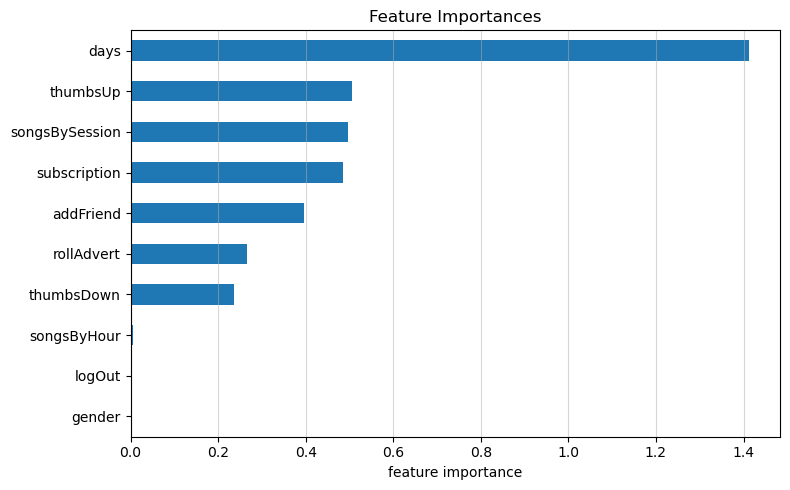

In [122]:
# plotting: feature importances
plt.figure(figsize=(8, 5))
importances.plot(kind='barh', title='Feature Importances')
plt.xlabel('feature importance')
plt.grid(axis='x', alpha=0.5)
plt.tight_layout()
plt.show()

`Observation`:
- The number of days since registration is the feature with the most impact on our logistic regression model.
- Gender, log-out actions, and the number of songs played per hour have the least impact on the predictive model. 

# Conclusions

### Reflection
This project utilized a modest dataset of 128MB with 225 unique customers. Following data loading and cleaning, we conducted an exploratory data analysis to identify predictive features for customer churn. This process yielded a set of promising features, which were subsequently preprocessed and employed in conjunction with various machine learning algorithms. The Logistic Regression algorithm demonstrated the best performance with reasonable time complexity, and after model tuning, we achieved an accuracy and F1 score of 0.75 and an accuracy of 0.77. 

The music service provider (Sparkify) can leverage these findings to identify at-risk customers and proactively offer retention incentives, resulting in revenue preservation for the company and potential benefits for the customer:
- Given the observed higher churn rate among newer customers, a targeted approach could involve offering complimentary premium service trials, free from advertisements.
- Furthermore, developing a refined music recommendation system could enhance user satisfaction by suggesting more relevant content, thereby increasing thumbs-up and reducing thumbs-down actions.

This project provided experience in utilizing Spark for data manipulation and feature engineering to predict customer churn. Spark MLlib was employed to develop machine learning models for this purpose. A key aspect of the project was leveraging customer interaction data to predict churn probability. The Logistic Regression classifier proved to be the most effective model, achieving an accuracy of 0.77 and F1 score of 0.75. It was interesting to clean data and build a predictive model for churn prediction using a big data technology (Spark) as opposed to non-distributed technologies like Scikit-learn and Pandas. 

### Future Work
This project could be improved with the following directions:
- extract more features from the user interaction data to be used in the predictive model. For example, the improved model can consider the number of artists that each user listen to, which is a potential feature for churn prediction.
- investigate other machine learning algorithms that are suitable for the binary classificationi of churn prediction. For example, deep learning algorithms can be investigated to examine hidden features in the user interaction data.
- investigate to deal with the overfitting problem and the imbalance of data labels.
